In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import enum
import simpy
import scipy as sc
import math
import networkx as nx  
import numpy as np
import pandas as pd
import re
import yaml as yaml
import time
import bisect
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import xarray as xr

from osgeo import gdal
from scipy import interpolate
from scipy.signal import correlate
from shapely.ops import transform,split,snap
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import import_hydrodynamic_dataset
from opentnsim import vessel_traffic_service
from opentnsim import port
from opentnsim import lock
from opentnsim import vessel
from opentnsim import waterway
from opentnsim import output
from opentnsim import tidal_window_constructor
from opentnsim import rule_constructor
from opentnsim import regulations

# spatial libraries 
import shapely.geometry
from shapely.geometry import Point
import shapely.wkt
import pyproj
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate systemb
geod = pyproj.Geod(ellps="WGS84")

location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

In [2]:
from opentnsim import lock as loc

In [3]:
from opentnsim import lock

In [4]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []
coords = []

coords.append([-56.223459,-34.905480]) #node_1
coords.append([-58.350448,-34.593781]) #node_2

for d in range(len(coords)):
    data_node = {"env": [],
                 "name": "Node_" + str(d+1),
                 "geometry": shapely.geometry.Point(coords[d][0], coords[d][1])}
    node = Node(**data_node)
    nodes.append(node)
    
for i in range(len(nodes)-1):
    path.append([nodes[i],nodes[i+1]]) 
    path.append([nodes[i+1],nodes[i]])

FG = nx.MultiDiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    geometry = shapely.geometry.LineString([FG.nodes[edge[0].name]['geometry'],FG.nodes[edge[1].name]['geometry']])
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {},geometry=geometry)
    
for node in FG.nodes:
    FG.nodes[node]['Info'] = {}

In [5]:
wgs = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:22185')
wgs_to_utm = pyproj.Transformer.from_crs(wgs,utm,always_xy=True).transform
utm_to_wgs = pyproj.Transformer.from_crs(utm,wgs,always_xy=True).transform

In [6]:
for node in FG.nodes:
    FG.nodes[node]['geometry'] = transform(wgs_to_utm,FG.nodes[node]['geometry'])
    
for edge in FG.edges:
    geometry = transform(wgs_to_utm,FG.edges[edge]['geometry'])
    length = geometry.length
    FG.edges[edge]['geometry'] = geometry
    FG.edges[edge]['Info']['geometry'] = geometry
    FG.edges[edge]['Info']['length'] = length

In [7]:
simulation_start = datetime.datetime.now()
duration = pd.Timedelta(365*24*3600,'s') #seconds
sim = model.Simulation(graph=FG,simulation_duration=duration)
env = sim.environment

In [8]:
lock_1 = lock.IsLock(env = sim.environment, 
                     name = 'Canal_Punta_Indio',
                     distance_doors1_from_first_waiting_area = 1000,   
                     distance_doors2_from_second_waiting_area=1000,
                     node_doors1 = "Node_1", node_doors2 = "Node_2",speed_reduction_factor=1.0,
                     lock_length = FG.edges['Node_1','Node_2',0]['Info']['length']-2000, lock_width = 24, lock_depth = 4.5, 
                     doors_open = 0, doors_close = 0, disch_coeff = 0.8,mandatory_time_gap_between_entering_vessels=0,
                     opening_area = 4.0, opening_depth = 5.0,levelling_time=0,used_as_one_way_traffic_regulation=True,
                     detector_nodes=['Node_1','Node_2'], priority_rules = regulations.ConditionalRule('start_node','==','Node_2'))

lineup_area_1 = lock.IsLockLineUpArea(env = sim.environment, name = 'Canal_Punta_Indio', distance_to_lock_doors = 0, 
                                      speed_reduction_factor=1.0,start_node = "Node_1",end_node = "Node_2", lineup_length = 1000)

lineup_area_2 = lock.IsLockLineUpArea(env = sim.environment, name = "Canal_Punta_Indio", distance_to_lock_doors = 0,
                                      speed_reduction_factor=1.0,start_node = "Node_2",end_node = "Node_1", lineup_length = 1000)

waiting_area_1 = lock.IsLockWaitingArea(env = sim.environment, name = 'Canal_Punta_Indio', distance_from_node=0,
                                        node = "Node_1")
    
waiting_area_2 = lock.IsLockWaitingArea(env = sim.environment, name = "Canal_Punta_Indio", distance_from_node=0,
                                        node = "Node_2")

In [9]:
Vessel = type('Vessel', 
              (core.SimpyObject, core.Identifiable, lock.HasWaitingArea, lock.HasLock, lock.HasLineUpArea, core.Movable, vessel.VesselProperties, output.HasOutput, vessel.ExtraMetadata), {})

In [10]:
def create_vessel(name,FG,origin,destination,length,beam,draught,height,v,arrival_time):
    vessel_input = { "name":name,
                     "geometry":FG.nodes[origin]['geometry'],
                     "origin":origin,
                     "destination":destination,
                     #"next_destination":next_destination,
                     "route":nx.dijkstra_path(FG,origin,destination),
                     "env":env,
                     "type":'Tanker',
                     "B":beam,
                     "L":length,
                     "T": draught,
                     "H":height,
                     #"t_berthing":berthing_time.total_seconds(),
                     #"t_(un)loading":[time.total_seconds() for time in unloading_time],
                     #"t_turning":[time.total_seconds() for time in turning_time],
                     #"ukc":ukc,
                     "v":v,
                     #"terminal_of_call": terminal_of_call,
                     #"berth_of_call": berth_of_call,
                     #"(un)loading": delta_draught,
                     #"max_waiting_time":datetime.timedelta(days=10).total_seconds(),
                     #"max_cross_current":max_cross_current,
                     "arrival_time":arrival_time,
                     #"arrival_delay":arrival_time,
                     #"priority": 0,
                     #"additional_waiting_time": additional_waiting_time/np.timedelta64(1, 's'),
                     #"bound":bound,
                     #"priority":False
                   }
    return vessel_input

In [11]:
created_vessel = Vessel(**create_vessel(name = 'test_vessel_1',
                                        FG = FG,
                                        origin='Node_1',
                                        destination='Node_2',
                                        length=200,
                                        beam=35,
                                        draught=10,
                                        height=5,
                                        v=6.5,
                                        arrival_time=sim.environment.simulation_start))
sim.add_vessels(vessel=created_vessel)

created_vessel = Vessel(**create_vessel(name = 'test_vessel_2',
                                        FG = FG,
                                        origin='Node_2',
                                        destination='Node_1',
                                        length=200,
                                        beam=35,
                                        draught=10,
                                        height=5,
                                        v=6.5,
                                        arrival_time=sim.environment.simulation_start))
sim.add_vessels(vessel=created_vessel)

created_vessel = Vessel(**create_vessel(name = 'test_vessel_3',
                                        FG = FG,
                                        origin='Node_1',
                                        destination='Node_2',
                                        length=200,
                                        beam=35,
                                        draught=10,
                                        height=5,
                                        v=6.5,
                                        arrival_time=sim.environment.simulation_start+pd.Timedelta(10000,'s')))
sim.add_vessels(vessel=created_vessel)



In [12]:
sim.run()

In [13]:
vessels = sim.environment.vessels

In [14]:
times = []
distances = []
positions = []

for _vessel_ in vessels:
    sailed_edges = []
    for edge in zip(_vessel_.route[:-1],_vessel_.route[1:]):
        sailed_edges.append(_vessel_.env.FG.edges[edge[0],edge[1],0]['geometry'])

    for loc,geom in enumerate(sailed_edges):
        if loc:
            multi_line = shapely.geometry.MultiLineString([geometry, geom])
            final_geometry = shapely.ops.linemerge(multi_line)
        else:
            final_geometry = geom
            
    vessel_time = []
    vessel_locations = []
    for loc,message in pd.DataFrame(_vessel_.log).iterrows():
        vessel_time.append(message.Time)
        vessel_locations.append(message.Location)
    
    vessel_distance = []
    for loc,location in enumerate(vessel_locations):
        if not loc:
            vessel_distance.append(0)
            continue
            
        geometries = split(snap(final_geometry, location, tolerance=100), location).geoms
        if len(geometries) > 1:
            vessel_distance.append(geometries[0].length)
        else:
            if loc >= len(vessel_locations)-2:
                vessel_distance.append(geometries[0].length)
            else:
                vessel_distance.append(vessel_distance[-1])
    
    if _vessel_.route[0] == 'Node_2':
        vessel_distance = [final_geometry.length-distance for distance in vessel_distance]
        
    times.append(vessel_time)
    distances.append(vessel_distance)
    positions.append(vessel_locations)

In [15]:
pd.DataFrame(vessels[0].log)

,Time,Location,Action,Status
0,2023-12-22 15:08:23.000000,POINT (5845236.409927413 6131342.613428857),Sailing from node Node_1 to node Node_2 start,"{'origin': '', 'destination': '', 'route': [],..."
1,2023-12-22 15:08:23.000000,POINT (5845236.409927413 6131342.613428857),Sailing to position in line-up area start,{}
2,2023-12-22 15:10:41.461539,POINT (5844354.841569792 6131523.823888931),Sailing to position in line-up area stop,{}
3,2023-12-22 15:10:41.461539,POINT (5844354.841569792 6131523.823888931),Sailing to end of line-up area start,{}
4,2023-12-22 15:10:56.846154,POINT (5844256.889530055 6131543.958384495),Sailing to end of line-up area stop,{}
5,2023-12-22 15:10:56.846154,POINT (5844256.889530055 6131543.958384495),Sailing to assigned location in lock start,{}
6,2023-12-22 23:32:38.083719,POINT (5652605.844354197 6170938.718608986),Sailing to assigned location in lock stop,{}
7,2023-12-22 23:32:38.083719,POINT (5652605.844354197 6170938.718608986),Passing lock start,{}
8,2023-12-22 23:32:38.083719,POINT (5652605.844354197 6170938.718608986),Passing lock stop,{}
9,2023-12-22 23:32:38.083719,POINT (5652605.844354197 6170938.718608986),Sailing to second pair of lock doors start,{}


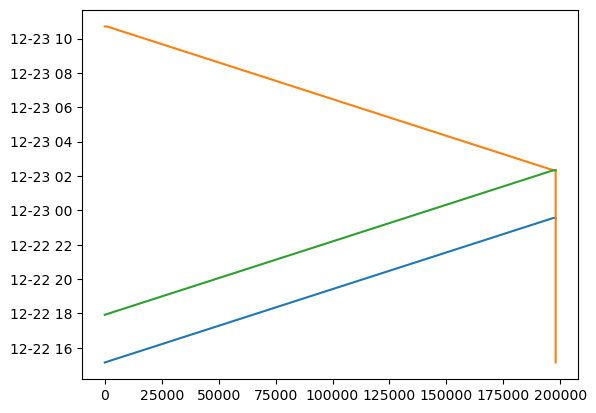

In [16]:
for time,distance in zip(times,distances):
    plt.plot(distance,time)
#plt.axvline(lock_1.distance_to_lock_doors1,color='k',linestyle='-.')
#plt.axvline(FG.edges['Node_1','Node_2',0]['geometry'].length-lock_1.distance_to_lock_doors2,color='k',linestyle='-.');

In [17]:
pd.DataFrame(vessels[2].log)

,Time,Location,Action,Status
0,2023-12-22 17:55:03.000000,POINT (5845236.409927413 6131342.613428857),Sailing from node Node_1 to node Node_2 start,"{'origin': '', 'destination': '', 'route': [],..."
1,2023-12-22 17:55:03.000000,POINT (5845236.409927413 6131342.613428857),Sailing to position in line-up area start,{}
2,2023-12-22 17:57:21.461539,POINT (5844354.841569792 6131523.823888931),Sailing to position in line-up area stop,{}
3,2023-12-22 17:57:21.461539,POINT (5844354.841569792 6131523.823888931),Sailing to end of line-up area start,{}
4,2023-12-22 17:57:36.846154,POINT (5844256.889530055 6131543.958384495),Sailing to end of line-up area stop,{}
5,2023-12-22 17:57:36.846154,POINT (5844256.889530055 6131543.958384495),Sailing to assigned location in lock start,{}
6,2023-12-23 02:18:47.314488,POINT (5652801.748433669 6170898.449617858),Sailing to assigned location in lock stop,{}
7,2023-12-23 02:18:47.314488,POINT (5652801.748433669 6170898.449617858),Passing lock start,{}
8,2023-12-23 02:18:47.314488,POINT (5652801.748433669 6170898.449617858),Passing lock stop,{}
9,2023-12-23 02:18:47.314488,POINT (5652801.748433669 6170898.449617858),Sailing to second pair of lock doors start,{}


In [18]:
pd.DataFrame(vessels[2].log)

,Time,Location,Action,Status
0,2023-12-22 17:55:03.000000,POINT (5845236.409927413 6131342.613428857),Sailing from node Node_1 to node Node_2 start,"{'origin': '', 'destination': '', 'route': [],..."
1,2023-12-22 17:55:03.000000,POINT (5845236.409927413 6131342.613428857),Sailing to position in line-up area start,{}
2,2023-12-22 17:57:21.461539,POINT (5844354.841569792 6131523.823888931),Sailing to position in line-up area stop,{}
3,2023-12-22 17:57:21.461539,POINT (5844354.841569792 6131523.823888931),Sailing to end of line-up area start,{}
4,2023-12-22 17:57:36.846154,POINT (5844256.889530055 6131543.958384495),Sailing to end of line-up area stop,{}
5,2023-12-22 17:57:36.846154,POINT (5844256.889530055 6131543.958384495),Sailing to assigned location in lock start,{}
6,2023-12-23 02:18:47.314488,POINT (5652801.748433669 6170898.449617858),Sailing to assigned location in lock stop,{}
7,2023-12-23 02:18:47.314488,POINT (5652801.748433669 6170898.449617858),Passing lock start,{}
8,2023-12-23 02:18:47.314488,POINT (5652801.748433669 6170898.449617858),Passing lock stop,{}
9,2023-12-23 02:18:47.314488,POINT (5652801.748433669 6170898.449617858),Sailing to second pair of lock doors start,{}


## Implementation

In [19]:
with open('FG.pickle', 'rb') as handle:
    FG = pickle.load(handle)

In [20]:
FG_Canal_Punta_Indio = FG.subgraph(nx.dijkstra_path(FG,'Zona De Alijo','KM_99'))

In [21]:
FG_Canal_Punta_Indio = FG_Canal_Punta_Indio.to_directed()

In [22]:
for edge in FG_Canal_Punta_Indio.edges:
    geometry = transform(wgs_to_utm,FG_Canal_Punta_Indio.edges[edge]['geometry'])
    FG_Canal_Punta_Indio.edges[edge]['Info'] = {}
    FG_Canal_Punta_Indio.edges[edge]['geometry'] = geometry
    FG_Canal_Punta_Indio.edges[edge]['Info']['geometry'] = geometry
    FG_Canal_Punta_Indio.edges[edge]['Info']['length'] = geometry.length
    
for node in FG_Canal_Punta_Indio.nodes:
    geometry = transform(wgs_to_utm,FG_Canal_Punta_Indio.nodes[node]['geometry'])
    FG_Canal_Punta_Indio.nodes[node]['Info'] = {}
    FG_Canal_Punta_Indio.nodes[node]['geometry'] = geometry

In [23]:
for edge in FG_Canal_Punta_Indio.edges:
    geometry = FG_Canal_Punta_Indio.edges[edge]['geometry']
    coordinates = geometry.coords.xy
    if not Point(coordinates[0][0],coordinates[1][0]) == FG_Canal_Punta_Indio.nodes[edge[0]]['geometry']:
        geometry = geometry.reverse()
    FG_Canal_Punta_Indio.edges[edge]['geometry'] = geometry
    FG_Canal_Punta_Indio.edges[edge]['Info']['geometry'] = geometry
    FG_Canal_Punta_Indio.edges[edge]['Info']['length'] = geometry.length

In [24]:
simulation_start = datetime.datetime.now()
duration = pd.Timedelta(365*24*3600,'s') #seconds
sim = model.Simulation(graph=FG_Canal_Punta_Indio,simulation_duration=duration)
env = sim.environment

In [25]:
def calculate_distance_between_nodes(FG,node_1,node_2):
    nodes = nx.dijkstra_path(FG,node_1,node_2)
    for loc,edge in enumerate(zip(nodes[:-1],nodes[1:])):
        geom = FG.edges[edge[0],edge[1],0]['geometry']
        if loc:
            multi_line = shapely.geometry.MultiLineString([final_geometry, geom])
            final_geometry = shapely.ops.linemerge(multi_line)
        else:
            final_geometry = geom
    return final_geometry.length

In [26]:
NoCrossing_KM140_KM150 = regulations.IsOneWayTrafficRegulation(env = sim.environment, 
                                                               name = 'Punta Indio KM140.8-KM150',
                                                               start_node_regulation = "Punta Indio KM_140.8",
                                                               end_node_regulation  = "Punta Indio KM_150",
                                                               node_waiting_area_I = "KM_99",
                                                               node_waiting_area_II = "Ponton Recalada",
                                                               conditions = {'Draught': 6.4},
                                                               priority_rules = regulations.ConditionalRule('start_node','==','KM_99'))

NoCrossing_KM150_KM182 = regulations.IsOneWayTrafficRegulation(env = sim.environment, 
                                                               name = 'Punta Indio KM150-KM182.7',
                                                               start_node_regulation = "Punta Indio KM_150",
                                                               end_node_regulation  = "Punta Indio KM_182.7",
                                                               node_waiting_area_I = "KM_99",
                                                               node_waiting_area_II = "Ponton Recalada",
                                                               conditions = {'Draught': 8.84},
                                                               priority_rules = regulations.ConditionalRule('start_node','==','KM_99'))

In [27]:
NoCrossing_KM194_KM201 = regulations.IsOneWayTrafficRegulation(env = sim.environment, 
                                                               name = 'Punta Indio KM194.4-KM201.6',
                                                               start_node_regulation = "Punta Indio KM_194.4",
                                                               end_node_regulation  = "Punta Indio KM_201.6",
                                                               node_waiting_area_I = "KM_99",
                                                               node_waiting_area_II = "Ponton Recalada",
                                                               conditions = {'Draught': 8.84},
                                                               priority_rules = regulations.ConditionalRule('start_node','==','KM_99'))

NoCrossing_KM210_KM216 = regulations.IsOneWayTrafficRegulation(env = sim.environment, 
                                                               name = 'Punta Indio KM210.0-KM216.0',
                                                               start_node_regulation = "Punta Indio KM_210",
                                                               end_node_regulation  = "Punta Indio KM_216",
                                                               node_waiting_area_I = "KM_99",
                                                               node_waiting_area_II = "Ponton Recalada",
                                                               conditions = {'Draught': 6.4},
                                                               priority_rules = regulations.ConditionalRule('start_node','==','KM_99'))

In [28]:
created_vessel = Vessel(**create_vessel(name = 'test_vessel1',
                                        FG = FG_Canal_Punta_Indio,
                                        origin='Ponton Recalada',
                                        destination='KM_99',
                                        length=200,
                                        beam=35,
                                        draught=9.0,
                                        height=5,
                                        v=12*0.5144444,
                                        arrival_time=sim.environment.simulation_start))
sim.add_vessels(vessel=created_vessel)

created_vessel = Vessel(**create_vessel(name = 'test_vessel2',
                                        FG = FG_Canal_Punta_Indio,
                                        origin='KM_99',
                                        destination='Ponton Recalada',
                                        length=200,
                                        beam=35,
                                        draught=9.0,
                                        height=5,
                                        v=12*0.5144444,
                                        arrival_time=sim.environment.simulation_start+pd.Timedelta(90,'m')))
sim.add_vessels(vessel=created_vessel)

created_vessel = Vessel(**create_vessel(name = 'test_vessel3',
                                        FG = FG_Canal_Punta_Indio,
                                        origin='Ponton Recalada',
                                        destination='KM_99',
                                        length=200,
                                        beam=35,
                                        draught=9.0,
                                        height=5,
                                        v=12*0.5144444,
                                        arrival_time=sim.environment.simulation_start+pd.Timedelta(4000,'s')))
sim.add_vessels(vessel=created_vessel)

created_vessel = Vessel(**create_vessel(name = 'test_vessel4',
                                        FG = FG_Canal_Punta_Indio,
                                        origin='Ponton Recalada',
                                        destination='KM_99',
                                        length=200,
                                        beam=35,
                                        draught=9.0,
                                        height=5,
                                        v=12*0.5144444,
                                        arrival_time=sim.environment.simulation_start+pd.Timedelta(16000,'s')))
sim.add_vessels(vessel=created_vessel)

In [29]:
sim.run()

In [30]:
1703206743.5356004 > 1703202957.9461875

True

In [31]:
1703208236.9234135 < 1703201464.5583744

False

In [32]:
vessels = sim.environment.vessels

In [33]:
times = []
distances = []
positions = []

for _vessel_ in vessels:
    sailed_edges = []
    for edge in zip(_vessel_.route[:-1],_vessel_.route[1:]):
        sailed_edges.append(_vessel_.env.FG.edges[edge[0],edge[1],0]['geometry'])

    for loc,geom in enumerate(sailed_edges):
        if loc:
            multi_line = shapely.geometry.MultiLineString([final_geometry, geom])
            final_geometry = shapely.ops.linemerge(multi_line)
        else:
            final_geometry = geom
            
    vessel_time = []
    vessel_locations = []
    for loc,message in pd.DataFrame(_vessel_.log).iterrows():
        vessel_time.append(message.Time)
        vessel_locations.append(message.Location)
    
    vessel_distance = []
    for loc,location in enumerate(vessel_locations):
        if not loc:
            vessel_distance.append(0)
            continue
            
        geometries = split(snap(final_geometry, location, tolerance=100), location).geoms
        if len(geometries) > 1:
            vessel_distance.append(geometries[0].length)
        else:
            if loc >= len(vessel_locations)-2:
                vessel_distance.append(geometries[0].length)
            else:
                vessel_distance.append(vessel_distance[-1])
    
    if _vessel_.route[0] == 'Ponton Recalada':
        vessel_distance = [final_geometry.length-distance for distance in vessel_distance]
        
    times.append(vessel_time)
    distances.append(vessel_distance)
    positions.append(vessel_locations)

In [34]:
Recalada = sim.environment.vessel_traffic_service.provide_trajectory(sim.environment,'KM_99','Ponton Recalada').length
KM216_0 = sim.environment.vessel_traffic_service.provide_trajectory(sim.environment,'KM_99','Punta Indio KM_216').length
KM210_0 = sim.environment.vessel_traffic_service.provide_trajectory(sim.environment,'KM_99','Punta Indio KM_210').length
KM201_6 = sim.environment.vessel_traffic_service.provide_trajectory(sim.environment,'KM_99','Punta Indio KM_201.6').length
KM194_4 = sim.environment.vessel_traffic_service.provide_trajectory(sim.environment,'KM_99','Punta Indio KM_194.4').length
KM182_7 = sim.environment.vessel_traffic_service.provide_trajectory(sim.environment,'KM_99','Punta Indio KM_182.7').length
KM150_0 = sim.environment.vessel_traffic_service.provide_trajectory(sim.environment,'KM_99','Punta Indio KM_150').length
KM140_8 = sim.environment.vessel_traffic_service.provide_trajectory(sim.environment,"KM_99","Punta Indio KM_140.8").length

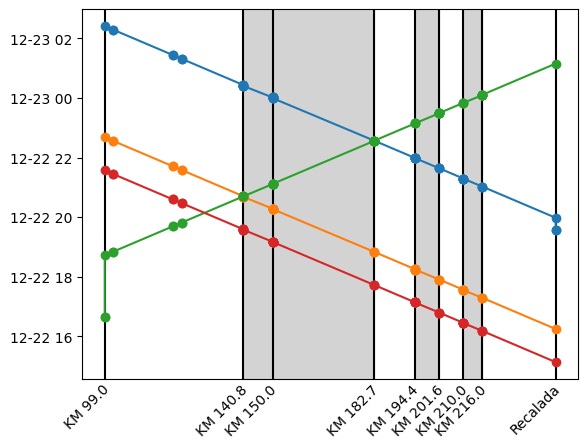

In [35]:
fig,ax = plt.subplots()
for time,distance in zip(list(reversed(times)),list(reversed(distances))):
    ax.plot(distance,time,marker='o',zorder=2)
ax.axvline(0,color='k',zorder=1)
ax.axvline(Recalada,color='k',zorder=1)
ax.axvline(KM216_0,color='k',zorder=1)
ax.axvline(KM210_0,color='k',zorder=1)
ax.axvline(KM201_6,color='k',zorder=1)
ax.axvline(KM194_4,color='k',zorder=1)
ax.axvline(KM182_7,color='k',zorder=1)
ax.axvline(KM150_0,color='k',zorder=1)
ax.axvline(KM140_8,color='k',zorder=1)
ax.set_xticks([])
ylim = ax.get_ylim()
ax.fill([KM140_8,KM140_8,KM150_0,KM150_0],[ylim[0],ylim[1],ylim[1],ylim[0]],color='lightgrey',zorder=0)
ax.fill([KM150_0,KM150_0,KM182_7,KM182_7],[ylim[0],ylim[1],ylim[1],ylim[0]],color='lightgrey',zorder=0)
ax.fill([KM194_4,KM194_4,KM201_6,KM201_6],[ylim[0],ylim[1],ylim[1],ylim[0]],color='lightgrey',zorder=0)
ax.fill([KM210_0,KM210_0,KM216_0,KM216_0],[ylim[0],ylim[1],ylim[1],ylim[0]],color='lightgrey',zorder=0)

ax.text(1500,ylim[0]-0.015,'KM 99.0',rotation=45,horizontalalignment='right',verticalalignment='baseline',rotation_mode='anchor');
ax.text(KM140_8+1500,ylim[0]-0.015,'KM 140.8',rotation=45,horizontalalignment='right',verticalalignment='baseline',rotation_mode='anchor');
ax.text(KM150_0+1500,ylim[0]-0.015,'KM 150.0',rotation=45,horizontalalignment='right',verticalalignment='baseline',rotation_mode='anchor');
ax.text(Recalada+1500,ylim[0]-0.015,'Recalada',rotation=45,horizontalalignment='right',verticalalignment='baseline',rotation_mode='anchor')
ax.text(KM210_0+1500,ylim[0]-0.015,'KM 210.0',rotation=45,horizontalalignment='right',verticalalignment='baseline',rotation_mode='anchor')
ax.text(KM216_0+1500,ylim[0]-0.015,'KM 216.0',rotation=45,horizontalalignment='right',verticalalignment='baseline',rotation_mode='anchor')
ax.text(KM201_6+1500,ylim[0]-0.015,'KM 201.6',rotation=45,horizontalalignment='right',verticalalignment='baseline',rotation_mode='anchor')
ax.text(KM194_4+1500,ylim[0]-0.015,'KM 194.4',rotation=45,horizontalalignment='right',verticalalignment='baseline',rotation_mode='anchor')
ax.text(KM182_7+1500,ylim[0]-0.015,'KM 182.7',rotation=45,horizontalalignment='right',verticalalignment='baseline',rotation_mode='anchor')
ax.set_ylim(ylim);

In [36]:
pd.DataFrame(vessels[1].log)

,Time,Location,Action,Status
0,2023-12-22 16:38:23.000000,POINT (5740679.650833956 6140369.161640978),Sailing from node KM_99 to node Intermedio KM_...,"{'origin': '', 'destination': '', 'route': [],..."
1,2023-12-22 16:38:23.000000,POINT (5740679.650833956 6140369.161640978),Waiting in line-up area start,{}
2,2023-12-22 18:43:30.483304,POINT (5740679.650833956 6140369.161640978),Waiting in line-up area stop,{}
3,2023-12-22 18:50:31.150762,POINT (5742861.865191668 6138961.349472031),Sailing from node KM_99 to node Intermedio KM_...,"{'origin': '', 'destination': '', 'route': [],..."
4,2023-12-22 18:50:31.150762,POINT (5742861.865191668 6138961.349472031),Sailing from node Intermedio KM_99.2 to node I...,"{'origin': '', 'destination': '', 'route': [],..."
5,2023-12-22 19:41:48.432107,POINT (5754727.107309522 6124155.801496149),Sailing from node Intermedio KM_99.2 to node I...,"{'origin': '', 'destination': '', 'route': [],..."
6,2023-12-22 19:41:48.432107,POINT (5754727.107309522 6124155.801496149),Sailing from node Intermedio KM_118.5 to node ...,"{'origin': '', 'destination': '', 'route': [],..."
7,2023-12-22 19:49:26.069823,POINT (5756599.579499035 6122041.70408791),Sailing from node Intermedio KM_118.5 to node ...,"{'origin': '', 'destination': '', 'route': [],..."
8,2023-12-22 19:49:26.069823,POINT (5756599.579499035 6122041.70408791),Sailing from node Punta Indio KM_121 to node P...,"{'origin': '', 'destination': '', 'route': [],..."
9,2023-12-22 20:42:12.512107,POINT (5769915.568297772 6107818.599154207),Sailing from node Punta Indio KM_121 to node P...,"{'origin': '', 'destination': '', 'route': [],..."


In [37]:
NoCrossing_KM140_KM150.env.FG.edges[NoCrossing_KM140_KM150.start_node_regulation,NoCrossing_KM140_KM150.end_node_regulation,0]['Lock'][0].schedule

direction                ETA  \
Name                      VesselName                                  
Punta Indio KM140.8-KM150 test_vessel1         0  1703288421.631092   
                          test_vessel3         0  1703292421.631092   
                          test_vessel2         1  1703293915.018905   
                          test_vessel4         0  1703305856.564831   

                                                      ETD Length Beam Draught  \
Name                      VesselName                                            
Punta Indio KM140.8-KM150 test_vessel1  1703289915.018905    200   35     9.0   
                          test_vessel3  1703293915.018905    200   35     9.0   
                          test_vessel2  1703295408.406718    200   35     9.0   
                          test_vessel4  1703307349.952644    200   35     9.0   

                                       VesselType Priority  
Name                      VesselName                        
Punta Indio KM140.8-KM150 test_vessel1     Tanker        0  
                          test_vessel3     Tanker        0  
                          test_vessel2     Tanker       -1  
                          test_vessel4     Tanker        0

In [38]:
NoCrossing_KM150_KM182.env.FG.edges[NoCrossing_KM150_KM182.start_node_regulation,NoCrossing_KM150_KM182.end_node_regulation,0]['Lock'][0].schedule

direction                ETA  \
Name                      VesselName                                  
Punta Indio KM150-KM182.7 test_vessel1         0  1703283197.552035   
                          test_vessel3         0  1703287197.552035   
                          test_vessel2         1  1703295408.406718   
                          test_vessel4         0  1703300632.485775   

                                                      ETD Length Beam Draught  \
Name                      VesselName                                            
Punta Indio KM150-KM182.7 test_vessel1  1703288421.631092    200   35     9.0   
                          test_vessel3  1703292421.631092    200   35     9.0   
                          test_vessel2  1703300632.485775    200   35     9.0   
                          test_vessel4  1703305856.564831    200   35     9.0   

                                       VesselType Priority  
Name                      VesselName                        
Punta Indio KM150-KM182.7 test_vessel1     Tanker        0  
                          test_vessel3     Tanker        0  
                          test_vessel2     Tanker       -1  
                          test_vessel4     Tanker        0

In [39]:
vessels_waiting_time = {}
for vessel in vessels:
    vessels_waiting_time[vessel.name] = 0
    if 'Waiting in line-up area start' in vessel.log['Action'][1]:
        vessels_waiting_time[vessel.name] = (vessel.log['Time'][2]-vessel.log['Time'][1])/np.timedelta64(1,'m')

In [40]:
vessels_waiting_time

{'test_vessel1': 0,
 'test_vessel2': 125.12472173333333,
 'test_vessel3': 0,
 'test_vessel4': 23.915562333333334}

In [41]:
sum(vessels_waiting_time.values())

149.04028406666666